## Compare fitness function and EA 

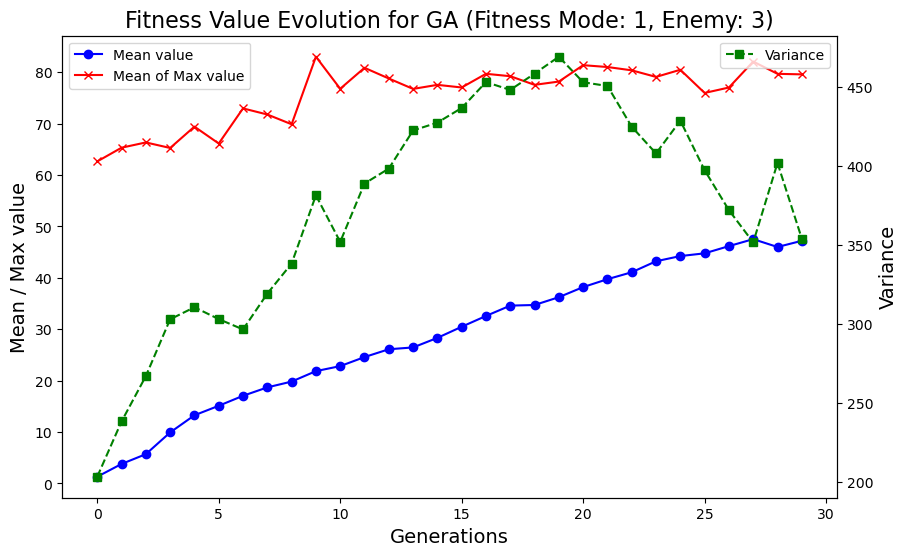

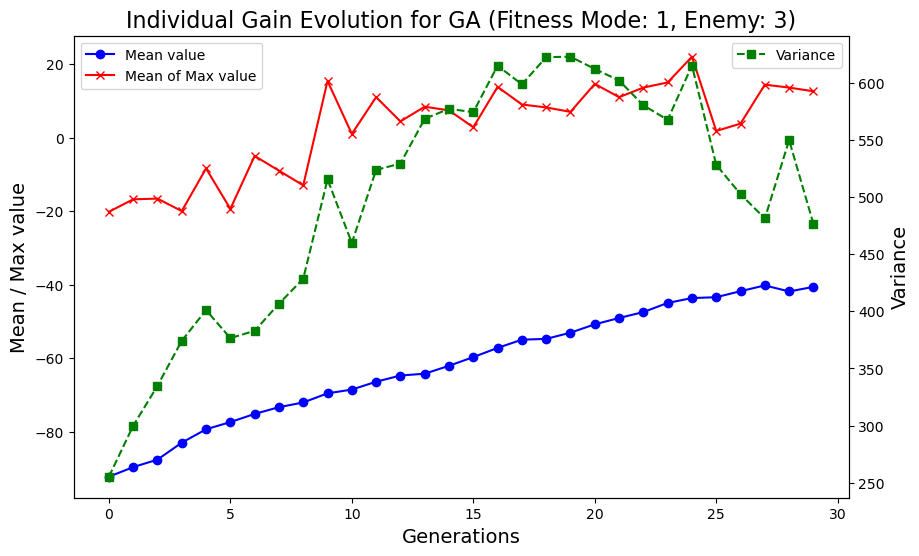

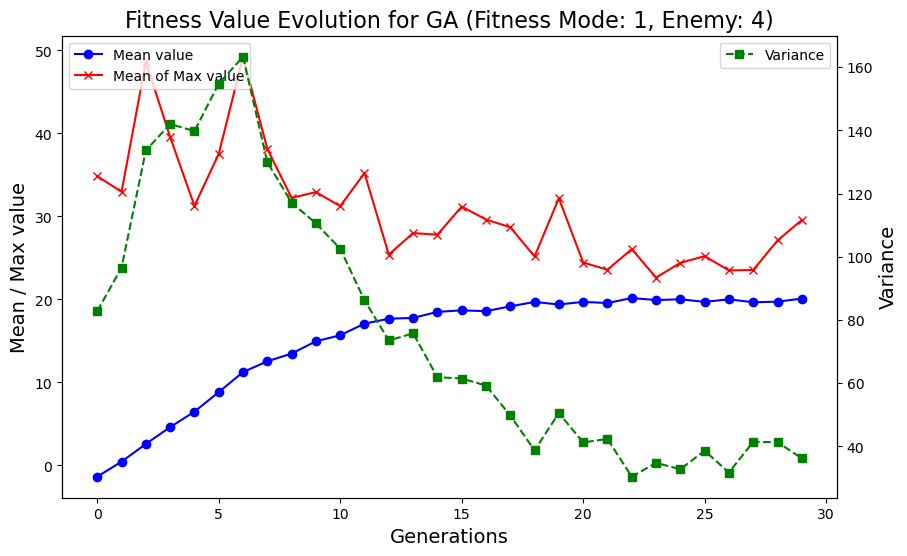

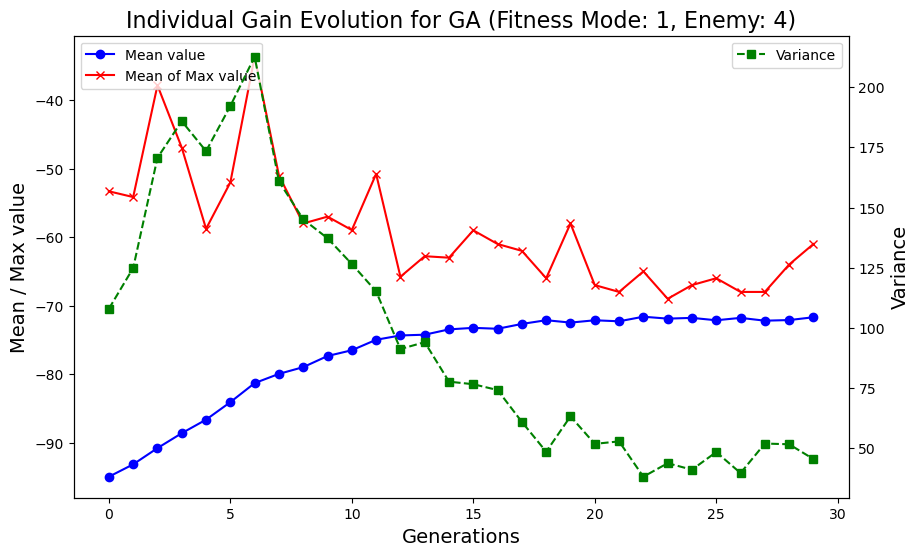

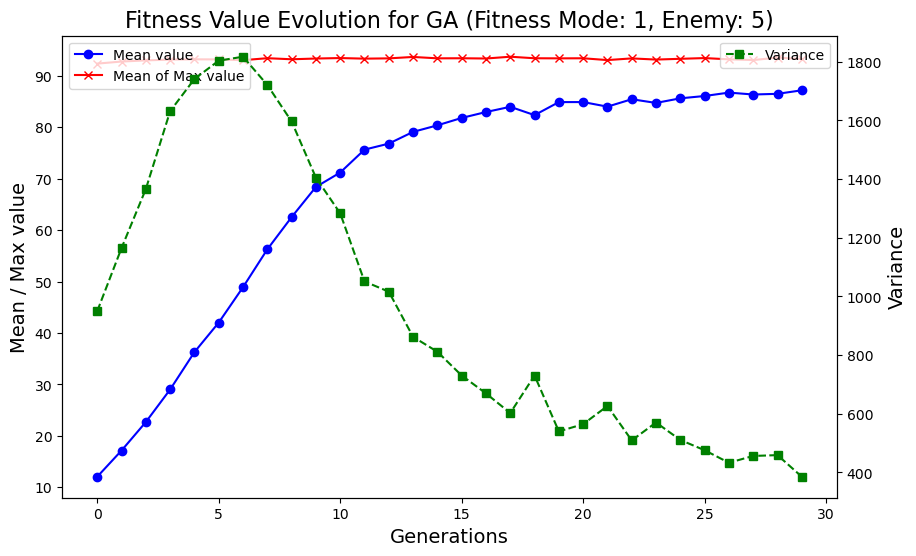

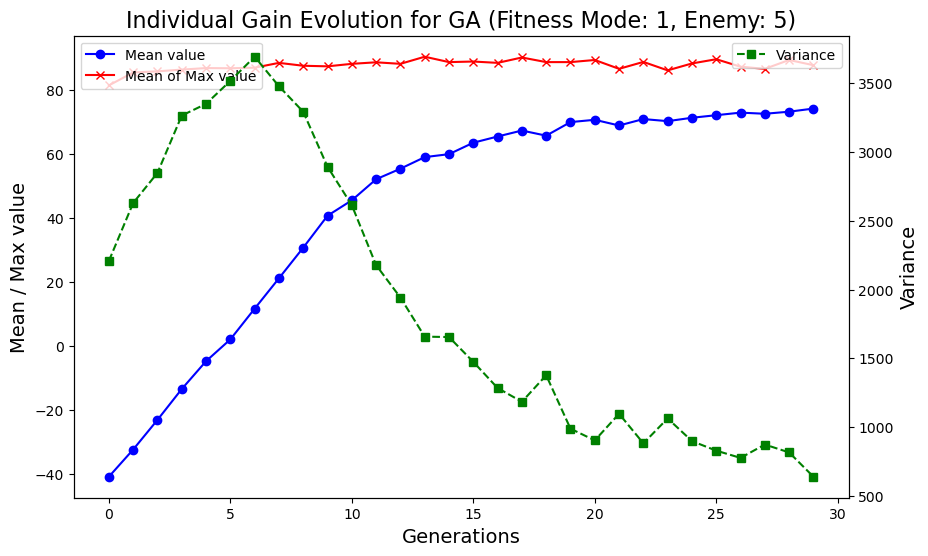

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define a function to plot the evolution of the specified metric (mean, variance, max)
def plot_fitness_evolution(EA_variable, fitness_mode, enemy, metric='fitness_values'):
    base_folder = 'Group_96_data_for_plots'
    algorithm_folder = f"{base_folder}/{EA_variable}"
    fitness_folder = f"{algorithm_folder}/fitness_mode_{fitness_mode}"

    # Check if the folder exists
    if not os.path.exists(fitness_folder):
        raise FileNotFoundError(f"Folder {fitness_folder} does not exist.")
    
    # Store data for all run_ids across generations
    generations_data = [[] for _ in range(30)]  # Assuming 30 generations, adjust as needed

    # Loop through run1 to run10, reading data for each generation in each experiment
    for run_id in range(1, 11):  # Assuming 10 experiments
        # Now the run folder includes the enemy number
        run_folder = f"{fitness_folder}/enemy_{enemy}/run{run_id}"  # Updated directory for each enemy
        for generation in range(30):  # Assuming 30 generations
            gen_folder = f"{run_folder}/generation_{generation}_evaluation_enemy_{enemy}"
            metric_file = f"{gen_folder}/{metric}.txt"
            
            if not os.path.exists(metric_file):
                continue  # Skip this generation if the file does not exist
            
            # Read the metric data for each generation
            data = np.loadtxt(metric_file)
            generations_data[generation].append(data)
    
    # Prepare to store the mean, variance, and max for each generation
    means = []
    variances = []
    max_means = []

    # Compute the mean, variance, and mean of the max for each generation
    for generation_data in generations_data:
        # Concatenate all run_id data into one array
        generation_data_flat = np.concatenate(generation_data) if generation_data else np.array([])

        if generation_data_flat.size > 0:
            means.append(np.mean(generation_data_flat))
            variances.append(np.var(generation_data_flat))
            max_means.append(np.mean([np.max(run_data) for run_data in generation_data]))  # Mean of max per generation
        else:
            means.append(np.nan)
            variances.append(np.nan)
            max_means.append(np.nan)

    # Plot the evolution of mean, variance, and max across generations
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Set the left y-axis
    ax1.set_xlabel('Generations', fontsize=14)
    ax1.set_ylabel('Mean / Max value', fontsize=14)
    ax1.plot(range(30), means, marker='o', color='blue', label='Mean value')
    ax1.plot(range(30), max_means, marker='x', color='red', label='Mean of Max value')
    ax1.tick_params(axis='y')
    
    # Set the right y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Variance', fontsize=14)
    ax2.plot(range(30), variances, marker='s', color='green', label='Variance', linestyle='--')
    ax2.tick_params(axis='y')

    # Set the plot title
    metric_label = 'Fitness Value' if metric == 'fitness_values' else 'Individual Gain'
    plt.title(f'{metric_label} Evolution for {EA_variable} (Fitness Mode: {fitness_mode}, Enemy: {enemy})', fontsize=16)

    # Add legends to ensure all curves are displayed in the legend
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

# Example call
enemies = [3, 4, 5]
for enemy in enemies:
    # Plot the evolution of fitness_values
    plot_fitness_evolution(EA_variable="GA", fitness_mode=1, enemy=enemy, metric='fitness_values')
    
    # Plot the evolution of individual_gains
    plot_fitness_evolution(EA_variable="GA", fitness_mode=1, enemy=enemy, metric='individual_gains')


## Calculate final best individual *5

In [14]:
import os
import numpy as np
from evoman.environment import Environment
from demo_controller import player_controller

# 设置隐藏层神经元数
n_hidden_neurons = 10  # 根据训练时设置的隐藏层神经元数量进行设置

# 读取神经网络权重
def load_best_individual(EA_variable, fitness_mode, enemy, run):
    # 动态构建 best_individual.txt 的路径
    base_folder = 'Group_96_data_for_plots'
    file_path = f"{base_folder}/{EA_variable}/fitness_mode_{fitness_mode}/enemy_{enemy}/run{run}/best_individual.txt"
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    # 读取存储的神经网络权重（1D 数组）
    return np.loadtxt(file_path)

# 模拟神经网络，返回 fitness value
def simulate_best_individual(EA_variable, fitness_mode, enemy, run):
    # 加载最佳个体的神经网络权重
    weights = load_best_individual(EA_variable, fitness_mode, enemy, run)
    
    # 设置模拟环境的 experiment_name
    experiment_name = "best_individual_simulation"
    
    # 确保日志目录存在
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    
    # 设置模拟环境
    env = Environment(
        experiment_name=experiment_name,
        enemies=[enemy],  # 设置要评估的敌人
        playermode="ai",
        player_controller=player_controller(n_hidden_neurons),
        enemymode="static",
        level=2,
        speed="fastest",
        visuals=False  # 不显示图形
    )
    
    # 进行模拟并返回 fitness value
    fitness, player_energy, enemy_energy, time = env.play(pcont=weights)
    
    # 返回 fitness value
    return fitness

# 示例调用
EA_variable = "GA"
fitness_mode = 1
enemy = 3
run = 1

# 调用 simulate_best_individual 函数进行评估
fitness_value = simulate_best_individual(EA_variable, fitness_mode, enemy, run)
print(f"Fitness Value: {fitness_value}")



MESSAGE: Pygame initialized for simulation.
Fitness Value: 56.742332412117364
